In [2]:
#import ALL THE THINGS
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from ema_workbench import (Model, 
                           RealParameter, CategoricalParameter, Constant, 
                           ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, save_results, load_results)
from ema_workbench.connectors.pysd_connector import PysdModel
from ema_workbench.em_framework.evaluators import LHS
from ema_workbench.em_framework import util

import ema_workbench.analysis.pairs_plotting as pairs
import ema_workbench.analysis.plotting as emaplt

# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Finding Adaptation Tipping Points

### Output Data Analysis

In [41]:
outcomes = [ScalarOutcome('Deceased population'),
            ScalarOutcome('Infectious population'),
            ScalarOutcome('Recovered population'),
            ScalarOutcome('Susceptible population'),
            ScalarOutcome('Exposed population'), 
            ScalarOutcome('Infecting'), 
            ScalarOutcome('Dying'), 
            ScalarOutcome('Surviving')]

# Ensure the proper constant values based on information above
constants = [Constant('Initial deceased population', 0),
             Constant('Initial exposed population', 0),
             Constant('Initial infectious population', 1),
             Constant('Initial recovered population', 0),
             Constant('Initial susceptible population', 100000)]

In [42]:
mdl = PysdModel('Model', mdl_file='model/original.mdl')
mdl.outcomes = outcomes
mdl.constants = constants
mdl.time_horizon = 360

mdl.uncertainties = [RealParameter('Average incubation time', 0.5, 14),
                 RealParameter('Average infectious period', 7, 21),
                 RealParameter('Basic reproduction number', 0.5,5),
                 RealParameter('Case fatality rate', 0.01, 0.5), 
                 CategoricalParameter('Switch SEIR or SIR', [1,0])]
with MultiprocessingEvaluator(mdl) as evaluator:
    full = evaluator.perform_experiments(500, uncertainty_sampling=LHS)

mdl.uncertainties = [RealParameter('Average incubation time', 0.5, 14),
                 RealParameter('Average infectious period', 7, 21),
                 RealParameter('Basic reproduction number', 0.5,1.9),
                 RealParameter('Case fatality rate', 0.01, 0.5), 
                 CategoricalParameter('Switch SEIR or SIR', [1,0])]
with MultiprocessingEvaluator(mdl) as evaluator:
    low_infectious = evaluator.perform_experiments(500, uncertainty_sampling=LHS)
    
mdl.uncertainties = [RealParameter('Average incubation time', 0.5, 14),
                 RealParameter('Average infectious period', 7, 21),
                 RealParameter('Basic reproduction number', 1.9,5),
                 RealParameter('Case fatality rate', 0.01, 0.5), 
                 CategoricalParameter('Switch SEIR or SIR', [1,0])]
with MultiprocessingEvaluator(mdl) as evaluator:
    high_infectious = evaluator.perform_experiments(500, uncertainty_sampling=LHS)
    
mdl.uncertainties = [RealParameter('Average incubation time', 0.5, 14),
                 RealParameter('Average infectious period', 7, 21),
                 RealParameter('Basic reproduction number', 0.5,5),
                 RealParameter('Case fatality rate', 0.01, 0.15), 
                 CategoricalParameter('Switch SEIR or SIR', [1,0])]
with MultiprocessingEvaluator(mdl) as evaluator:
    low_fatality = evaluator.perform_experiments(500, uncertainty_sampling=LHS)
    
mdl.uncertainties = [RealParameter('Average incubation time', 0.5, 14),
                 RealParameter('Average infectious period', 7, 21),
                 RealParameter('Basic reproduction number', 0.5,5),
                 RealParameter('Case fatality rate', 0.15, 0.5), 
                 CategoricalParameter('Switch SEIR or SIR', [1,0])]
with MultiprocessingEvaluator(mdl) as evaluator:
    high_fatality = evaluator.perform_experiments(500, uncertainty_sampling=LHS)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


#### Deceased Population Analysis
To determine the proper value for the deceased population level leading to an adaptation tipping point, we looked at trends in the density of outcomes. The first graph indicates a significant change in density at around 12,000 deceased, so we set the `Deceased population` tipping point at 12 percent of the population. We then determined, through trial and error, the division of the `Case fatality rate` (the biggest factor directly affecting the stock) to determine the uncertainty ranges that would place the majority of case runs in the relevant buckets. The results are in the second and third charts in this section. 

The final result is the following: 

* Low fatality: 0.01 - 0.15
* High fatality: 0.15 - 0.5

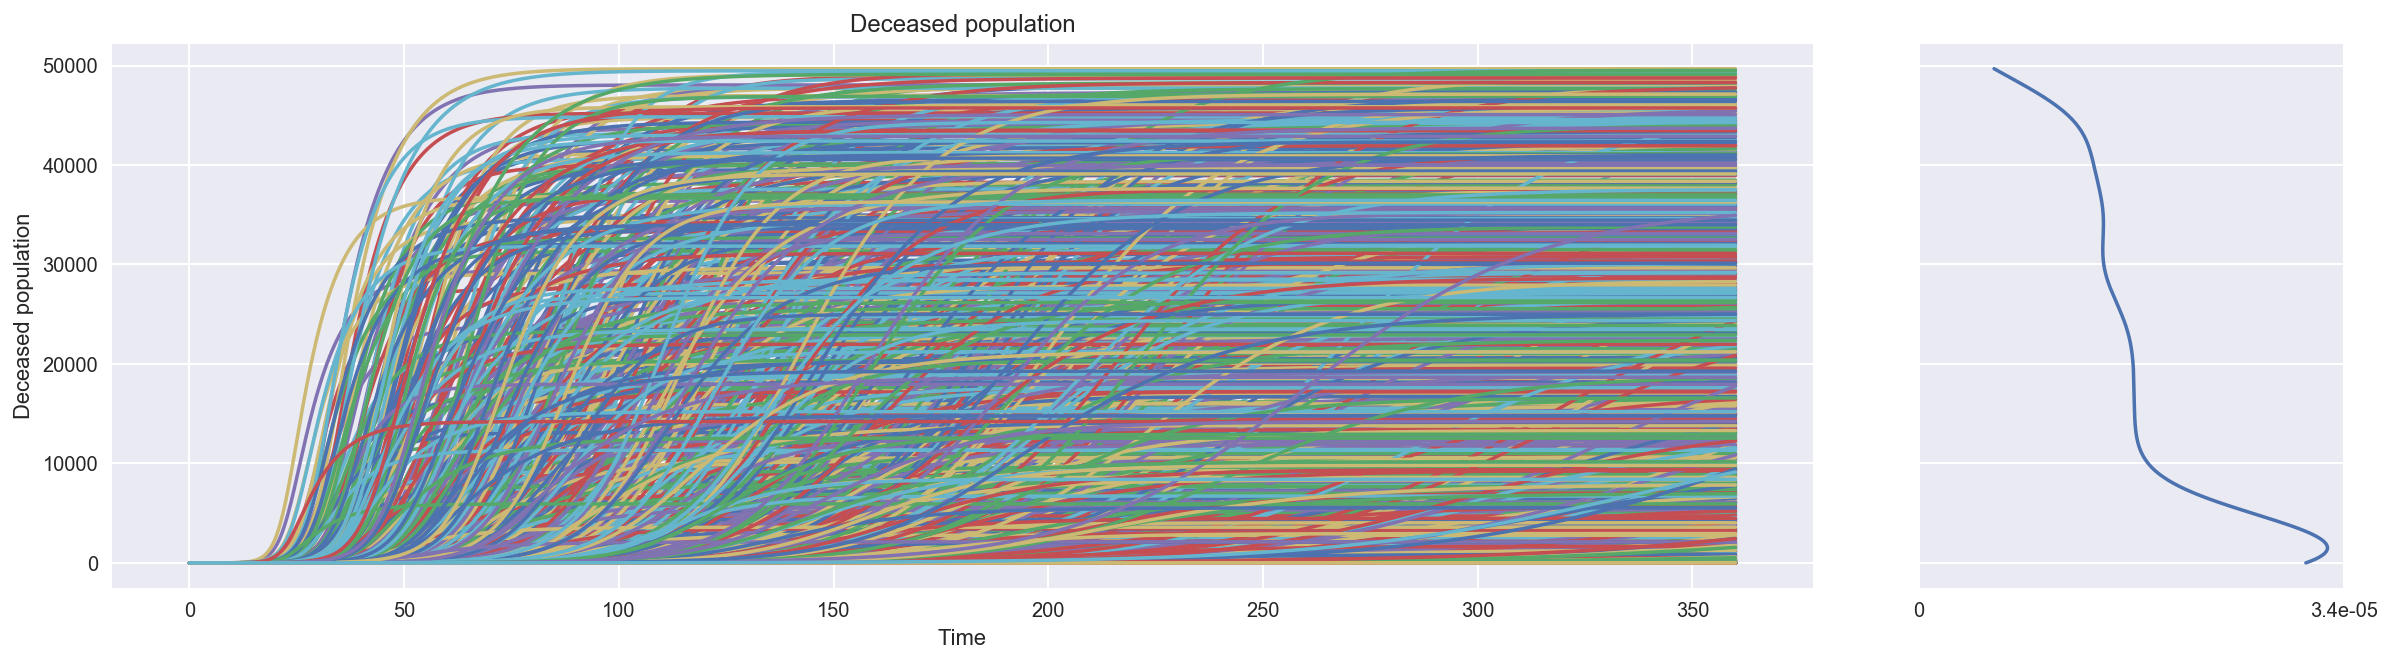

In [24]:
figure = emaplt.lines(full,density=u'kde',outcomes_to_show=['Deceased population'])
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

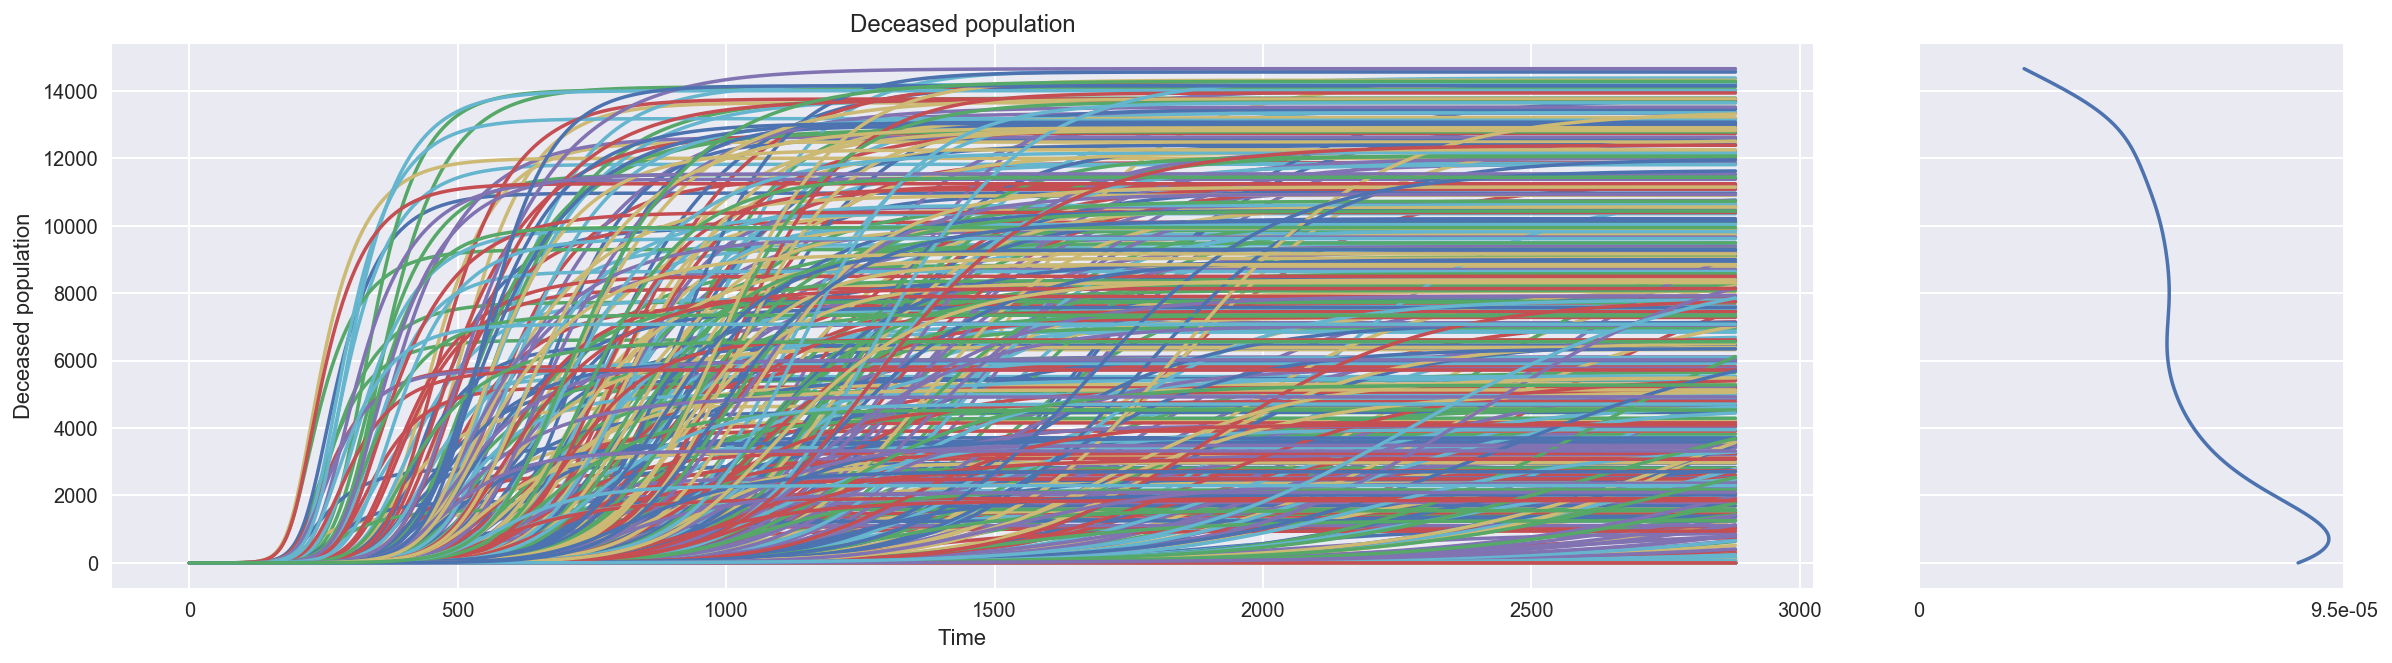

In [14]:
figure = emaplt.lines(low_fatality,density=u'kde',outcomes_to_show=['Deceased population'])
plt.rcParams["figure.figsize"] = (20,5)
plt.show() #show figure

In [15]:
figure = emaplt.lines(high_fatality,density=u'kde',outcomes_to_show=['Deceased population'])
plt.rcParams["figure.figsize"] = (20,5)
plt.show() #show figure

#### Infectious Population Analysis
This analysis required a different approach, due to `Infectious population` having both inflows and outflows. The density of values at the end of experiment runs will not provide an adqeuate description of the overall output space. Instead, we examined the densities of maximum values over several uncertainty space specifications. Based on a visual inspection and trial and error, a specification was found that divides the overall output uncertainty space in about half. The final result is the following: 

* Low infectious: 0.5 - 1.9
* High fatality: 1.9 - 5

In [27]:
figure = emaplt.lines(results,density=u'kde',outcomes_to_show=['Infectious population'])
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [62]:
infect_high = np.zeros(len(high_infectious[1]['Infectious population']))
for index, arr in enumerate(high_infectious[1]['Infectious population']):
    infect_high[index] = np.mean(arr)
    
infect_low = np.zeros(len(low_infectious[1]['Infectious population']))
for index, arr in enumerate(low_infectious[1]['Infectious population']):
    infect_low[index] = np.mean(arr)

infect = np.zeros(len(full[1]['Infectious population']))
for index, arr in enumerate(full[1]['Infectious population']):
    infect[index] = np.mean(arr)

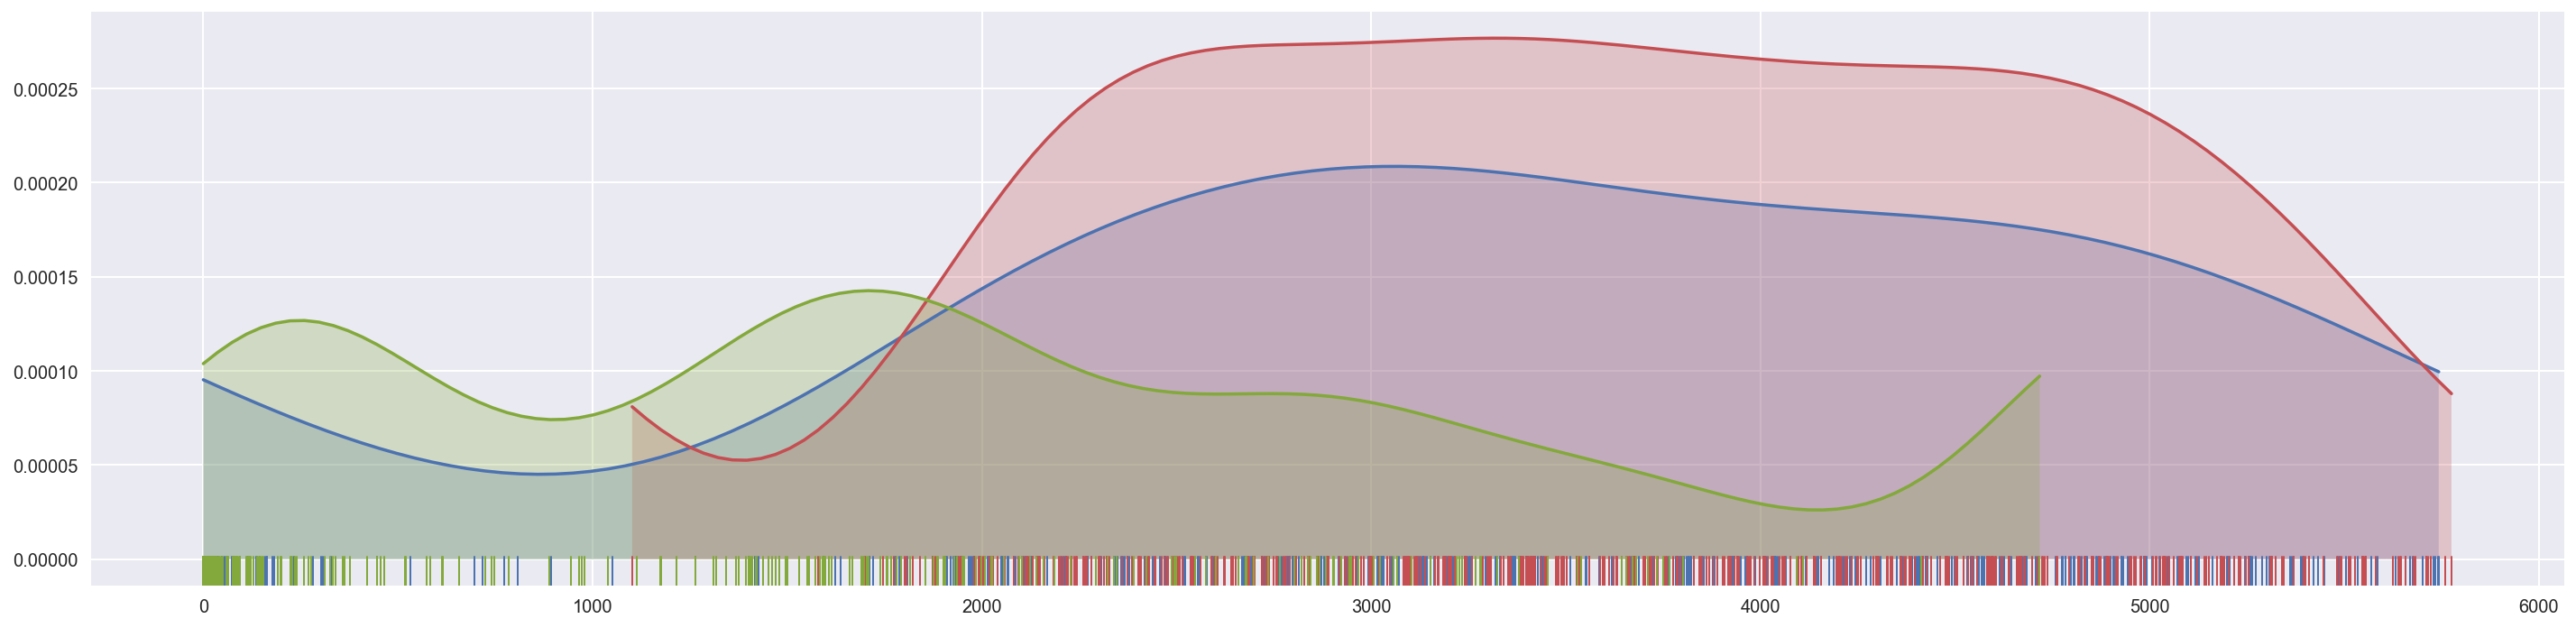

In [63]:
sns.kdeplot(infect, shade=True, cut=0)
sns.rugplot(infect)

sns.kdeplot(infect_high, shade=True, cut=0, color='r')
sns.rugplot(infect_high, color='r')

sns.kdeplot(infect_low, shade=True, cut=0, color = 'g')
sns.rugplot(infect_low, color='g')

plt.rcParams["figure.figsize"] = (20,5)
plt.show()

## Developing the Early Warning Triggers

#### Dying / Infectious Population
This provides a proxy for the `Case fatality rate`, which policy makers would not have access to when monitoring a system for adaptation tipping points. We have mapped the densities of the maximum values of this proxy in the first chart. From this, we have pulled three key behavioral segments: 

* Low fatality rate: rate < 0.015
* High fatality rate: 0.015 < rate < 0.045
* Super high fatality rate: 0.045 > rate

The super high fatality rate provides a way to recognize those infectious diseases that are at less dense though significantly more fatal top end of the uncertainty range. 

#### Infecting / Susceptible Population
This provides a proxy for the `Base reproduction rate`, which policy makers would not have access to when monitoring a system for adaptation tipping points. We have mapped the densities of the maximum values of this proxy in the first chart. In this case, the low infectious range was charted separately due to significant behavior differences from the other two groups. From this, we have pulled three key behavioral segments: 

* Slow infectious rate: rate < 0.015
* High infectious rate: 0.015 < rate < 0.045
* Super high infectious rate: 0.045 > rate

The super high fatality rate provides a way to recognize those infectious diseases that are at less dense though significantly more infectious top end of the uncertainty range. 

In [46]:
normal_max =  np.zeros(len(full[1]['Dying']))
for index, arr in enumerate(full[1]['Dying']):
    normal_max[index] = np.max(arr/full[1]['Infectious population'][index])
    
low_max =  np.zeros(len(low_infectious[1]['Dying']))
for index, arr in enumerate(low_infectious[1]['Dying']):
    low_max[index] = np.max(arr/low_infectious[1]['Infectious population'][index])
    
high_max =  np.zeros(len(high_infectious[1]['Dying']))
for index, arr in enumerate(high_infectious[1]['Dying']):
    high_max[index] = np.max(arr/high_infectious[1]['Infectious population'][index])

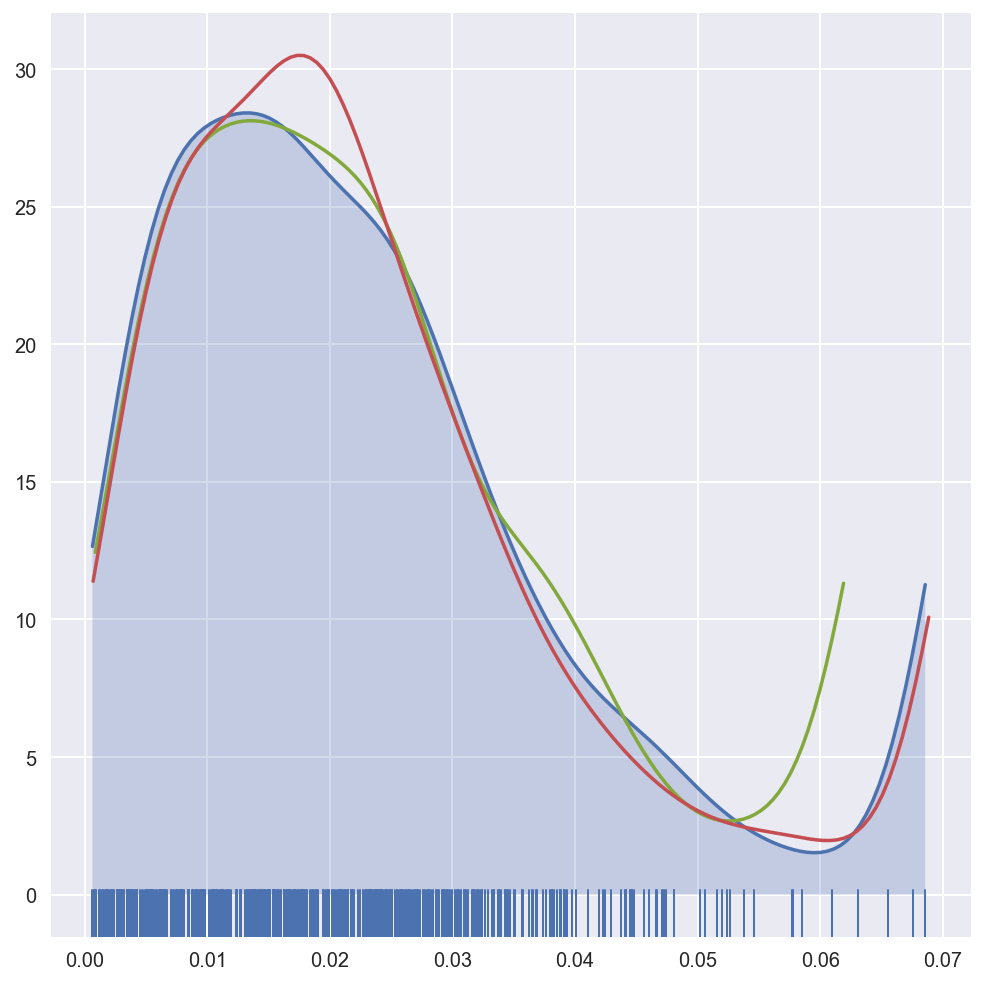

In [51]:
sns.kdeplot(normal_max, shade=True, cut=0)
sns.kdeplot(low_max, cut=0, color = 'g')
sns.kdeplot(high_max, cut=0, color = 'r')
sns.rugplot(normal_max)
plt.rcParams["figure.figsize"] = (7,7)
plt.show()

In [52]:
normal_max =  np.zeros(len(full[1]['Infecting']))
for index, arr in enumerate(full[1]['Infecting']):
    normal_max[index] = np.max(arr/full[1]['Susceptible population'][index])
    
low_max =  np.zeros(len(low_infectious[1]['Infecting']))
for index, arr in enumerate(low_infectious[1]['Infecting']):
    low_max[index] = np.max(arr/low_infectious[1]['Susceptible population'][index])
    
high_max =  np.zeros(len(high_infectious[1]['Infecting']))
for index, arr in enumerate(high_infectious[1]['Infecting']):
    high_max[index] = np.max(arr/high_infectious[1]['Susceptible population'][index])

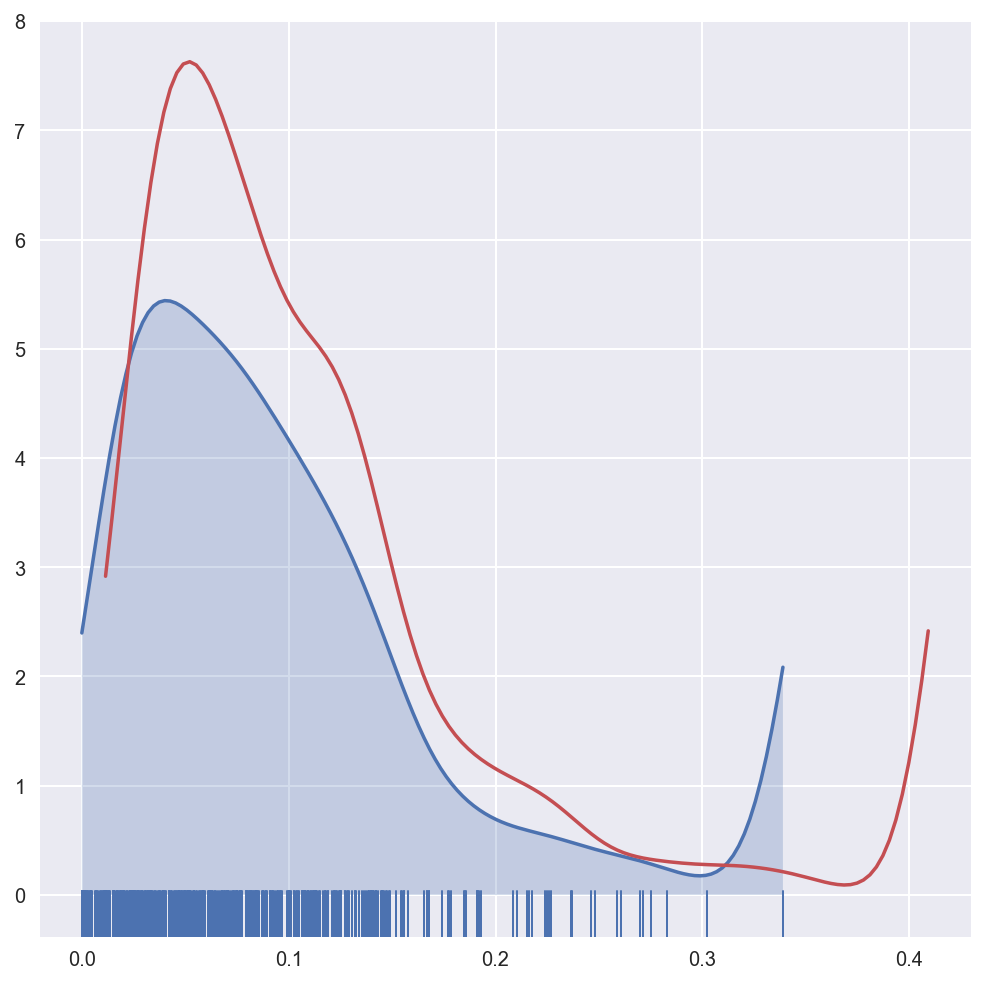

In [54]:
sns.kdeplot(normal_max, shade=True, cut=0)
sns.kdeplot(high_max, cut=0, color = 'r')
sns.rugplot(normal_max)
plt.rcParams["figure.figsize"] = (7,7)
plt.show()

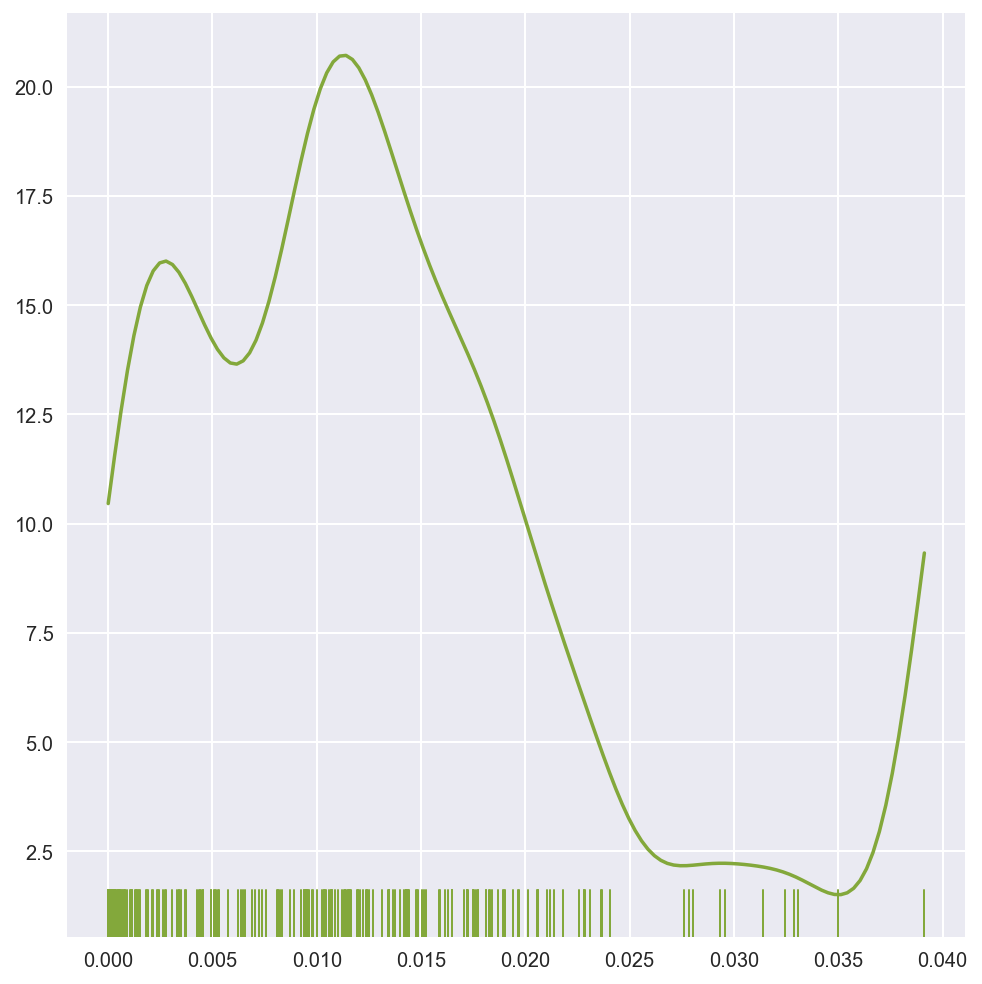

In [57]:
sns.kdeplot(low_max, cut=0, color = 'g')
sns.rugplot(low_max, color='g')
plt.rcParams["figure.figsize"] = (7,7)
plt.show()